This notebook generates an array of values (potential, velocity) for a Capytaine configuration, to visually compare with MEEM approximations.

Most blocks take a few minutes to run, don't rerun this notebook.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import sys
import os
sys.path.append(os.path.relpath('../../'))
sys.path.append(os.path.relpath('../'))
from multi_condensed import Problem
from capytaine_generator import CapytaineSlantSolver
from helpers import *

import pickle

In [3]:
# Formerly data generation, now data loading
css = CapytaineSlantSolver(True, True, True, True, True)
file1 = "data/capytaine-point-values.pkl"

h = 50
a = [4, 9]
d_in = [30, 30]
d_out = [30, 5]
heaving = [0, 1]
m0 = 1
rho = 1023

t_densities = [40, 70]
face_units = 100 # filler
f_densities = [15, 75, 15]

# respack = css.construct_and_solve(a, d_in, d_out, heaving, t_densities, face_units, h, m0, rho, 1, f_densities)
# rad_result = respack[0]
# res = 400
# pot_pack = css.plot_potential(h, a, d_in, d_out, res, rad_result, True)
# vel_pack = css.plot_velocities(h, a, d_in, d_out, res, rad_result, True)
# data = {"Real Potential" : pot_pack[0],
#         "Imag Potential" : pot_pack[1],
#         "Real Radial Velocity" : vel_pack[0],
#         "Imag Radial Velocity" : vel_pack[1],
#         "Real Vertical Velocity" : vel_pack[2],
#         "Imag Vertical Velocity" : vel_pack[3],
#         "rad_result" : rad_result}
# with open(file1, "wb") as f:
#   pickle.dump(data, f)

with open(file1, "rb") as f:
  data = pickle.load(f)

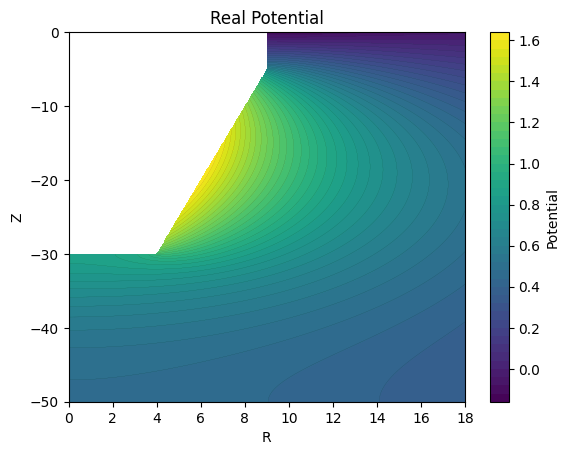

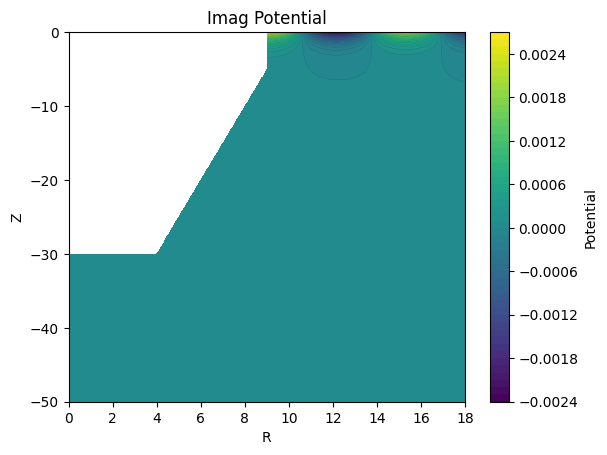

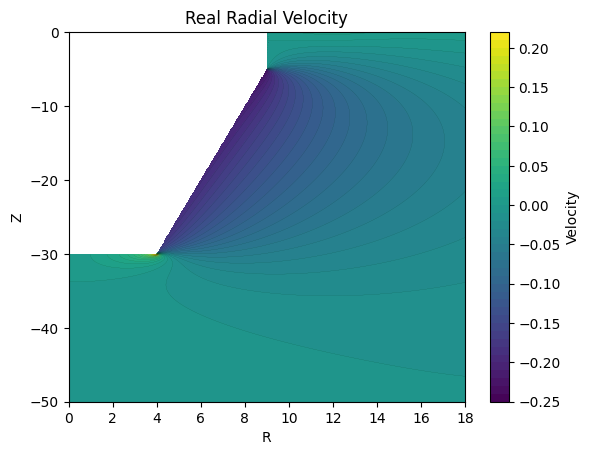

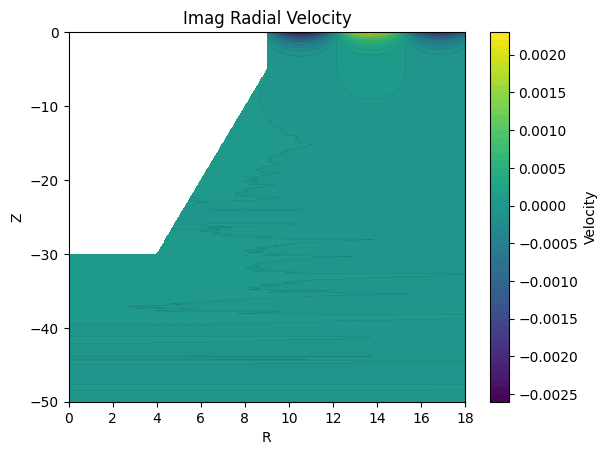

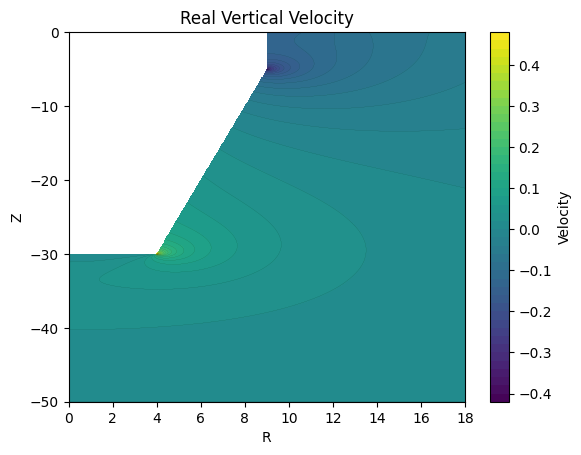

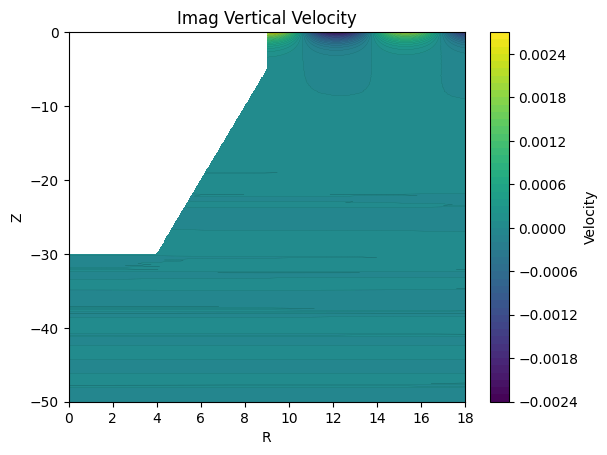

In [4]:
keys = ["Real Potential", "Imag Potential", 
        "Real Radial Velocity", "Imag Radial Velocity", 
        "Real Vertical Velocity", "Imag Vertical Velocity"]

for key in keys[:2]:
  css.plot_from_array(h, a, data[key], color_lab = "Potential", title = key)
for key in keys[2:]:
  css.plot_from_array(h, a, data[key], color_lab = "Velocity", title = key)

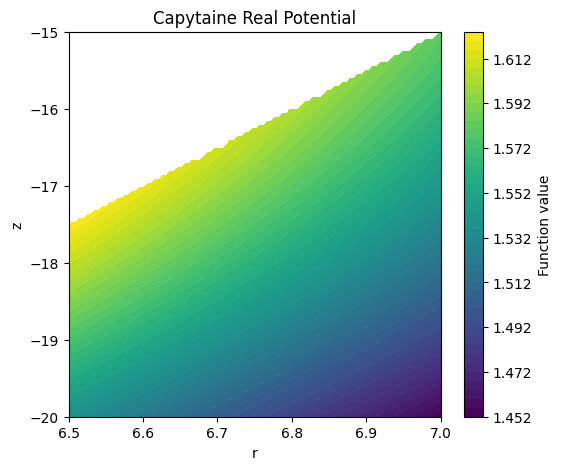

In [5]:
# Close-ups of what the capytaine potentials look like near the slant surface (few minutes to run).
def outline_function(r):
  region = 0
  for rad in a:
    if r <= rad: break
    else: region += 1
  if region == len(a): return 0
  elif d_in[region] == d_out[region]:
    return - d_in[region]
  else:
    inner_rad = 0 if region == 0 else a[region - 1]
    outer_rad = a[region]
    slope = (d_in[region] - d_out[region])/(outer_rad - inner_rad)
    return slope * (r - inner_rad) - d_in[region]

def plot_contour_cpt(rad_result, css, r_min, r_max, z_min, z_max, res = 50):
    # Generate grid
    r = np.linspace(r_min, r_max, res)
    z = np.linspace(z_min, z_max, res)
    R, Z = np.meshgrid(r, z)

    # Evaluate function
    def wrapper(r, z):
        if z > outline_function(r):
            return np.nan + 1j * np.nan
        else: return css.solver.compute_potential((r, 0, z), rad_result)
    vals = np.vectorize(wrapper, otypes=[complex])(R, Z) * 1j / rad_result.omega

    # Plot contour
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(R, Z, np.real(vals), cmap='viridis', levels = 50)
    plt.colorbar(contour, label='Function value')
    plt.xlabel('r')
    plt.ylabel('z')
    plt.title('Capytaine Real Potential')
    plt.show()

plot_contour_cpt(data["rad_result"], css, 6.5, 7, -20, -15, res = 100)

In [6]:
class PotentialProblem(Problem):
  def det_region(self, r):
    region = 0
    for i in range(self.boundary_count):
        if r <= self.a[i]:
            return region
        else: region += 1
    return region
  
  def phi_p_i(self, r, z, i): # particular solution
      return (1 / (2* (self.h - self.d[i]))) * ((z + self.h) ** 2 - (r**2) / 2)
  
  def potential(self, r, z, cs):
    region = self.det_region(r)
    nmk = self.NMK[region]
    nmks = list(range(nmk))
    if region == self.boundary_count: # Outermost
      lambda_vals = np.vectorize(self.Lambda_k, otypes=[complex])(nmks, r)
      z_vals = np.vectorize(self.Z_k_e, otypes=[complex])(nmks, z)
      return np.dot(cs[-1], lambda_vals * z_vals)
    else:
      phi_p = 0 if not self.heaving[region] else self.phi_p_i(r, z, region)
      r1_vals = np.vectorize(self.R_1n, otypes=[complex])(nmks, r, region)
      z_vals = np.vectorize(self.Z_n_i, otypes=[complex])(nmks, z, region)
      phi_h_1 = np.dot(cs[region][:nmk], r1_vals * z_vals)
      if region == 0: # Innermost
        return phi_p + phi_h_1
      else: # Typical region
        r2_vals = np.vectorize(self.R_2n, otypes=[complex])(nmks, r, region)
        phi_h_2 = np.dot(cs[region][nmk:], r2_vals * z_vals)
        return phi_p + phi_h_1 + phi_h_2

In [ ]:
def plot_contour_MEEM(prob, cs, r_min, r_max, z_min, z_max, res = 50):
    # Generate grid
    r = np.linspace(r_min, r_max, res)
    z = np.linspace(z_min, z_max, res)
    R, Z = np.meshgrid(r, z)

    # Evaluate function
    def wrapper(r, z):
        if z > outline_function(r):
            return np.nan + 1j * np.nan
        else: return prob.potential(r, z, cs)
    vals = np.vectorize(wrapper, otypes=[complex])(R, Z)

    # Plot contour
    plt.figure(figsize=(6, 5))
    contour = plt.contourf(R, Z, np.real(vals), cmap='viridis', levels = 50)
    plt.colorbar(contour, label='Function value')
    plt.xlabel('r')
    plt.ylabel('z')
    plt.title('MEEM Potential')
    plt.show()

def solve_problem(prob_style, h, a, d_in, d_out, heaving, m0, rho, res, version, nmk = 200):
  NMK = [nmk, nmk, nmk]
  d_prime, a_prime, heaving_prime, NMK_prime, _ = slant_approx_vars(a, d_in, d_out, heaving, NMK, res, version)
  prob = prob_style(h, d_prime, a_prime, heaving_prime, NMK_prime, m0, rho)
  a_matrix = prob.a_matrix()
  b_vector = prob.b_vector()
  x = prob.get_unknown_coeffs(a_matrix, b_vector)
  cs = prob.reformat_coeffs(x)
  return prob, x, cs

In [8]:
prob1, x1, cs1 = solve_problem(PotentialProblem, h, a, d_in, d_out, heaving, m0, rho, 40, 1)
prob2, x2, cs2 = solve_problem(PotentialProblem, h, a, d_in, d_out, heaving, m0, rho, 40, 2)
prob3, x3, cs3 = solve_problem(PotentialProblem, h, a, d_in, d_out, heaving, m0, rho, 40, 3)

In [13]:
probs, xs = [prob1, prob2, prob3], [x1, x2, x3]
print(f"Capytaine Added Mass: {data["rad_result"].added_mass["Heave"]:.4g}")
print(f"Capytaine Damping: {data["rad_result"].radiation_damping["Heave"]:.4g}")
for i in range(3):
  print("Approximation Version " + str(i + 1))
  am, dp = probs[i].hydro_coeffs(xs[i], "capytaine")
  print(f"Added Mass {am:.4g}")
  print(f"Damping {dp:.4g}")

Capytaine Added Mass: 2.952e+05
Capytaine Damping: 2.195
Approximation Version 1
Added Mass 3.1e+05
Damping 1.151
Approximation Version 2
Added Mass 3.064e+05
Damping 0.3258
Approximation Version 3
Added Mass 3.122e+05
Damping 0.6151


Approximation Form 1


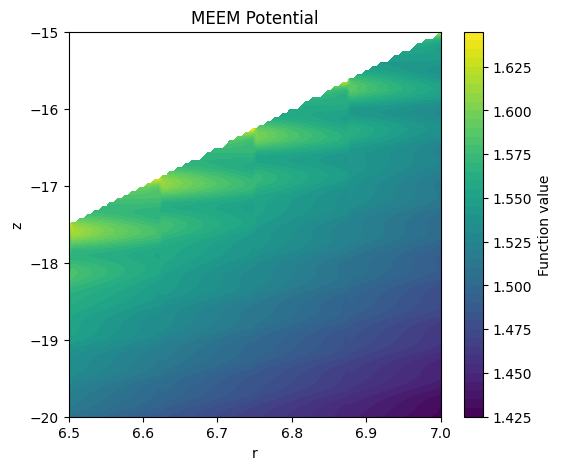

Approximation Form 2


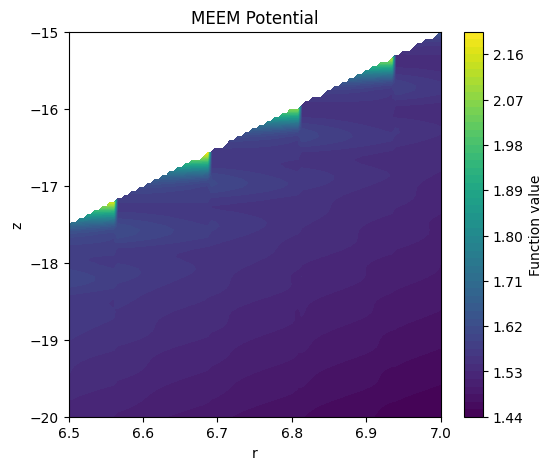

Approximation Form 3


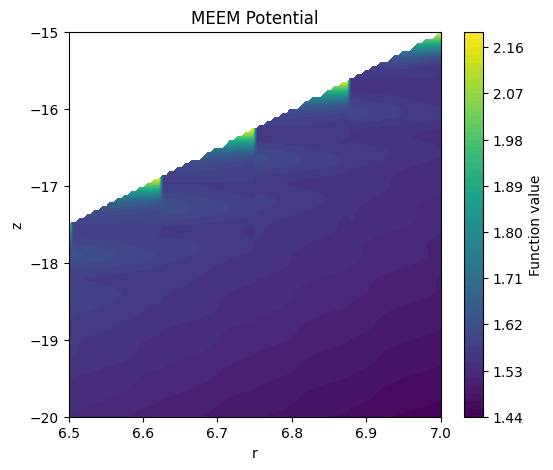

In [14]:
print("Approximation Form 1")
plot_contour_MEEM(prob1, cs1, 6.5, 7, -20, -15, res = 100)
print("Approximation Form 2")
plot_contour_MEEM(prob2, cs2, 6.5, 7, -20, -15, res = 100)
print("Approximation Form 3")
plot_contour_MEEM(prob3, cs3, 6.5, 7, -20, -15, res = 100)

In [15]:
print(f"Capytaine Added Mass: {data["rad_result"].added_mass["Heave"]:.4g}")
print(f"Capytaine Damping: {data["rad_result"].radiation_damping["Heave"]:.4g}")
for res in [10, 20, 30, 40]:
  prob, x, cs = solve_problem(PotentialProblem, h, a, d_in, d_out, heaving, m0, rho, res, 2, nmk = 200)
  am, dp = prob.hydro_coeffs(x, "capytaine")
  print(f"Resolution: {res}, Added mass: {am:.4g}, Damping: {dp:.4g}")

Capytaine Added Mass: 2.952e+05
Capytaine Damping: 2.195
Resolution: 10, Added mass: 3.365e+05, Damping: 0.01828
Resolution: 20, Added mass: 3.167e+05, Damping: 0.1322
Resolution: 30, Added mass: 3.095e+05, Damping: 0.2437
Resolution: 40, Added mass: 3.057e+05, Damping: 0.326


In [17]:
R, Z, phi, nanregions = prob2.config_potential_array(cs2, 400)

In [23]:
def plot_comparison(field, title, color):
    plt.figure(figsize=(8, 6))
    plt.contourf(R, Z, field, levels=50, cmap = color)
    plt.colorbar()
    plt.title(title)
    plt.xlabel('Radial Distance (R)')
    plt.ylabel('Axial Distance (Z)')
    plt.show()

def potential_comparison(p_real_cpt, p_imag_cpt, p_real_meem, p_imag_meem):
  plot_comparison(p_real_cpt, 'Capytaine Potential Real', "viridis")
  plot_comparison(p_real_meem, 'MEEM Potential Real', "viridis")
  plot_comparison(p_imag_cpt, 'Capytaine Potential Imaginary', "viridis")
  plot_comparison(p_imag_meem, 'MEEM Potential Imaginary', "viridis")

  meem_minus_cpt_real = p_real_meem - p_real_cpt
  meem_minus_cpt_imag = p_imag_meem - p_imag_cpt

  plot_comparison(meem_minus_cpt_real, 'Real Potential Difference', "plasma")
  plot_comparison(meem_minus_cpt_imag, 'Imag Potential Difference', "plasma")

  raw_fraction_real = (meem_minus_cpt_real)/p_real_cpt
  raw_fraction_imag = (meem_minus_cpt_imag)/p_imag_cpt

  fraction_real = replace_large_values(raw_fraction_real, 0.1)
  fraction_imag = replace_large_values(raw_fraction_imag, 1)

#   plot_comparison(raw_fraction_real, 'Fractional Real Potential Difference', "plasma")
#   plot_comparison(raw_fraction_imag, 'Fractional Imag Potential Difference', "plasma")
  plot_comparison(fraction_real, 'Fractional Real Potential Difference', "plasma")
  plot_comparison(fraction_imag, 'Fractional Imag Potential Difference', "plasma")

def replace_large_values(arr, limiting_value):
    return np.where(
        np.isnan(arr),           # Condition 1: keep NaNs
        np.nan,                  # Keep original NaN
        np.where(
            np.abs(arr) >= limiting_value,  # Condition 2: replace large values
            limiting_value,        # Replacement value
            arr                  # Keep small values
        )
    )

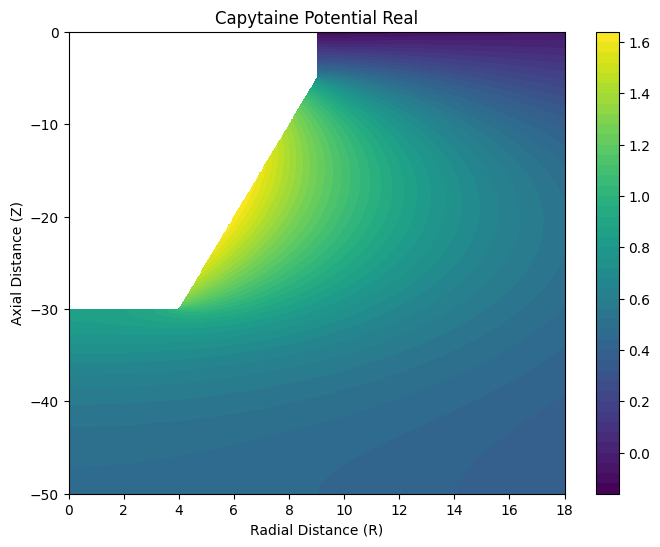

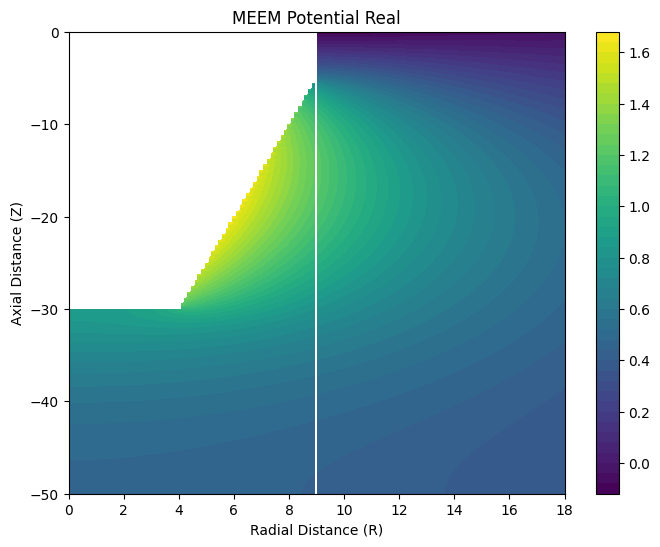

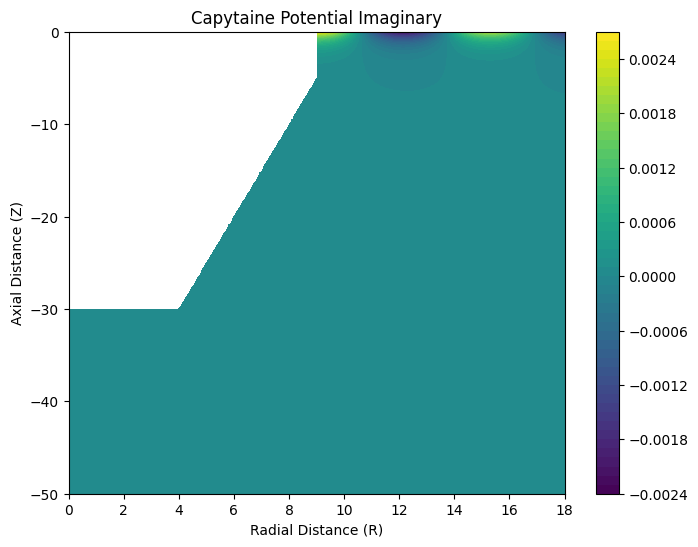

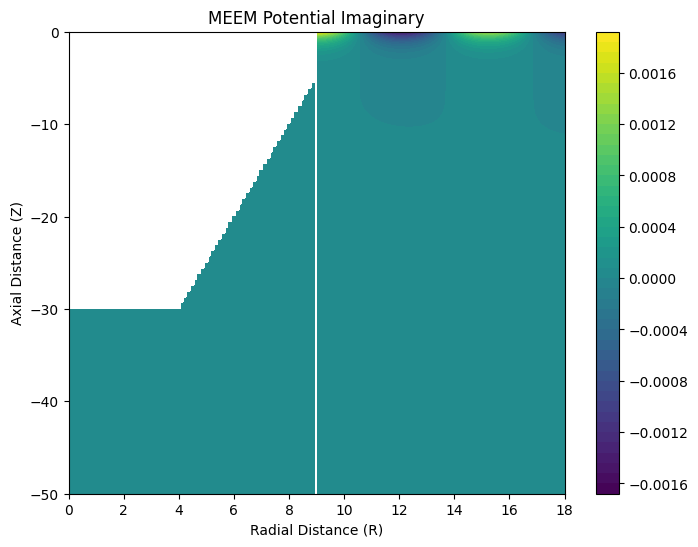

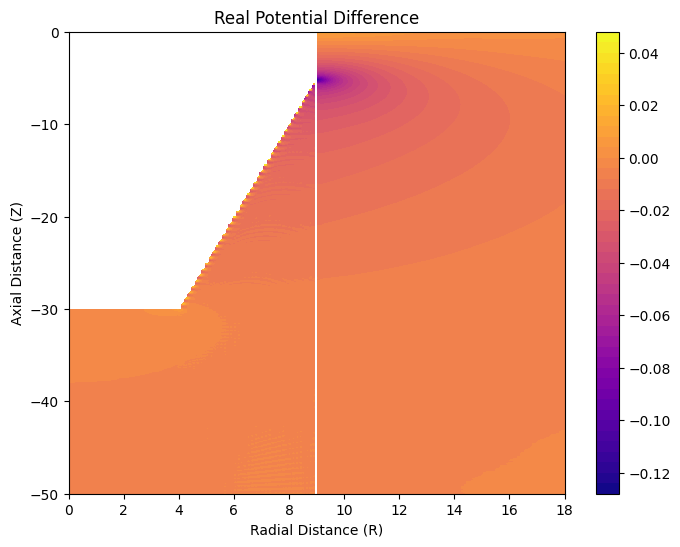

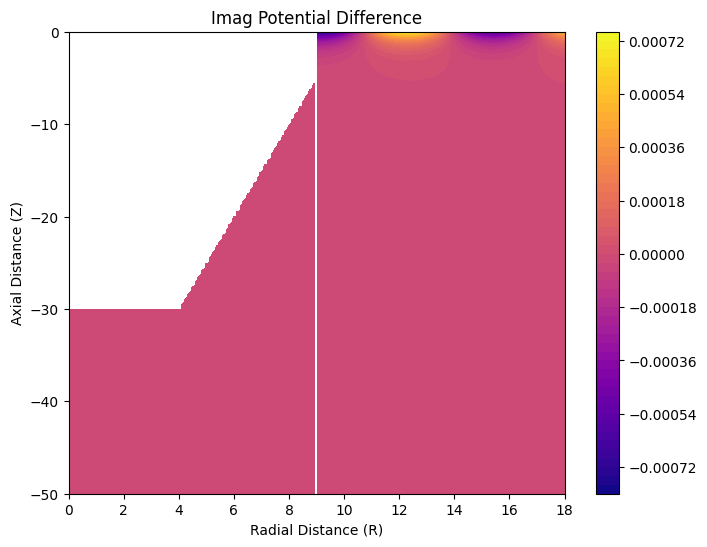

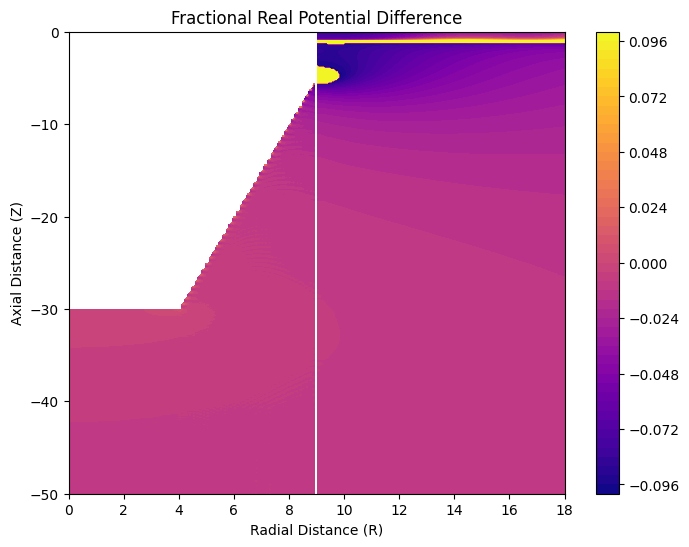

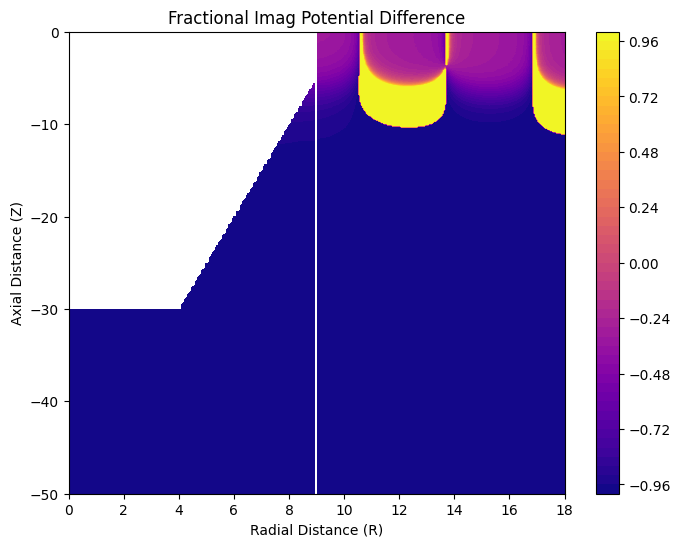

In [24]:
# Plots, there some kind of nan artifact from the MEEM potential generation (NOT part of the body)
# The yellow stands in for values more than that fraction off
potential_comparison(data["Real Potential"], data["Imag Potential"], np.real(phi), np.imag(phi))